In [1]:
import os
import cv2
from PIL import Image
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import torch

from torch.utils.data import Dataset
import torch.distributed as dist

import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


import references.transforms as T  # ?? delete class write your own

In [34]:
class PedestrianDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)


### Finetune from pretrained model

In [35]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#print(model)

In [36]:
num_classes = 2 # background and pedestrian
in_features = model.roi_heads.box_predictor.cls_score.in_features
print(f"Number of input features for the classifier: {in_features}")

# replace the pretrained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
#print(model)

Number of input features for the classifier: 1024


### compute the instance segmentation masks 

In [37]:
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # input features from mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # replace predictor with new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 
                                                      hidden_layer, 
                                                      num_classes)
    
    return model

In [38]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [39]:
def collate_fn_(batch):
    return tuple(zip(*batch))

In [40]:
def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format."""
    # Convert the bounding box (upper-left x, upper-left y, lower-right x,
    # lower-right y) format to the matplotlib format: ((upper-left x,
    # upper-left y), width, height)
    return plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

device :: cpu
Length training set: 120
Length test set: 50
{'boxes': tensor([[307.,  97., 406., 386.],
        [147., 100., 230., 394.],
        [ 30., 111., 147., 406.]]), 'labels': tensor([1, 1, 1]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8), 'image_id': tensor([63]), 'area': tensor([28611., 24402., 34515.]), 'iscrowd': tensor([0, 0

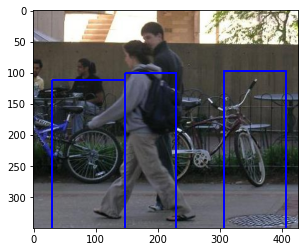

In [43]:
criterion = torch.nn.CrossEntropyLoss()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"device :: {device}")
num_classes = 2
dataset = PedestrianDataset("data", get_transform(train=True))
dataset_test = PedestrianDataset("data", get_transform(train=False))

# split dataset
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])
print(f"Length training set: {len(dataset)}")
print(f"Length test set: {len(dataset_test)}")
    
train_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=collate_fn_)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=4, collate_fn=collate_fn_)

model = get_model_instance_segmentation(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.6, weight_decay=0.0005)

#print(model)
inputs, labels = next(iter(train_loader))
im_id = labels[0]["image_id"].item()
print(labels[0])
print("------------")
boxes = labels[0]["boxes"]
np_boxes = []
for box in boxes:
    np_boxes.append(box.detach().numpy())

print(np_boxes)
    
print(im_id)
img_path = "./data/PNGImages/PennPed000" + str(im_id) + ".png"
img = Image.open(img_path)
fig = plt.imshow(img)

for box in np_boxes:
    fig.axes.add_patch(bbox_to_rect(box, "blue"))

In [42]:
def train(num_epochs=5, model=model, data_loader=train_loader):
    for epoch in range(num_epochs):
        model.train()
        loop = tqdm(data_loader, desc=f"Training Epoch #{epoch}")
        for idx, (images, targets) in enumerate(loop):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            print(targets)
            out_dic = model(images, targets)
            print(out_dic)
            losses = sum(loss for loss in out_dic.values())
            #print(f"Loss -- {loss_value}")
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
                

In [ ]:
train()

In [ ]:
# save model 
torch.save(model, "./model/model_v2.pth") 

# validation

In [ ]:
data_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
img_path = "./data/PNGImages/PennPed00073.png"
img = Image.open(img_path)
# Load model
model = torch.load("./model/model.pth")
model.to(device)
model.eval()
with torch.no_grad():
    img = data_transforms(img)
    img = img.to(device, dtype=torch.float32).unsqueeze(0)
    out = model(img)
    print(out)